# Exploring time series in python

Date started: 21st June 2022

In [1]:
# Packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import statsmodels.tsa.stattools as smt
from statsmodels.tsa.api import VAR

/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [29]:
# Use this to install any packages required in general:

# import subprocess
# import sys

# def install(package):
#    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
# install("johansen")

  Created wheel for johansen: filename=johansen-0.0.4-py3-none-any.whl size=5627 sha256=c635a23132fe3d5bd7c7dfc180875d0db6e4b97c9012843c89b5a87708c6a332
  Stored in directory: /Users/elliebloom/Library/Caches/pip/wheels/95/32/27/67d55f7c04b98ec0adecd8b52f6fdbcc2ace5452995389bdef
Successfully built johansen


In [3]:
# Useful dates


bank_holidays = ["2020-01-01","2020-04-10","2020-04-13","2020-05-08",
                          "2020-05-25","2020-08-31","2020-12-25","2020-12-28",
                          "2021-01-01","2021-04-02","2021-04-05","2021-05-03",
                          "2021-05-31","2021-08-30","2021-12-27","2021-12-28",
                          "2022-01-03","2022-04-15","2022-04-18","2022-05-02"]


type(bank_holidays[0]) # They are currently strings
bank_holidays = [dt.datetime.strptime(item, "%Y-%m-%d") for item in bank_holidays]
type(bank_holidays[0]) # Now datetime objects

lockdown_1_start = dt.datetime.strptime("2020-03-26","%Y-%m-%d")
lockdown_1_end = dt.datetime.strptime("2020-06-15","%Y-%m-%d")

lockdown_2_start = dt.datetime.strptime("2020-11-05","%Y-%m-%d")
lockdown_2_end = dt.datetime.strptime("2020-12-02","%Y-%m-%d")

lockdown_3_start = dt.datetime.strptime("2021-01-06","%Y-%m-%d")
lockdown_3_end = dt.datetime.strptime("2021-04-21","%Y-%m-%d")


REACT_start = dt.datetime.strptime("2020-05-01","%Y-%m-%d")

from dateutil.relativedelta import relativedelta
start_date = REACT_start
print(type(start_date))
end_date = lockdown_2_start-relativedelta(months=1)

print(f'Start date is: {start_date}, i.e. start of REACT data')
print(f'End date is: {end_date}, i.e. one month before the end of lockdown 1')

<class 'datetime.datetime'>
Start date is: 2020-05-01 00:00:00, i.e. start of REACT data
End date is: 2020-10-05 00:00:00, i.e. one month before the end of lockdown 1


## Time Series

Exploring Granger Causality using tutorial - https://rishi-a.github.io/2020/05/25/granger-causality.html

In [4]:
# Loading data

mob_long = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Mapping/Outputs/google_regional_long.csv", index_col='date',parse_dates=['date'])
mob_wide = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Mapping/Outputs/google_regional_wide.csv", index_col='date',parse_dates=['date'])
prev = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Time_series_analysis/Ouputs/Tibbles/prev_smooth_tibble.csv", index_col='d_comb',parse_dates=['d_comb'])

mob_long.index = pd.to_datetime(mob_long.index)
mob_wide.index = pd.to_datetime(mob_wide.index)

In [5]:
print("Column names in the long dataset are:")
for col in mob_long.columns:
    print(col)
    
print("Column names in the wide dataset are:")
for col in mob_wide.columns:
    print(col)
    
print("Column names in the prevalence dataset are:")
for col in prev.columns:
    print(col)

Column names in the long dataset are:
Unnamed: 0
region
type_mobility
mobility
Column names in the wide dataset are:
Unnamed: 0
region
retail_recreation
grocery_pharmacy
parks
transit_stations
workplaces
residential
retail_recreation_av
grocery_pharmacy_av
parks_av
transit_stations_av
workplaces_av
residential_av
Column names in the prevalence dataset are:
Unnamed: 0
x
p
lb_2.5
lb_25
ub_97.5
ub_75
region


In [6]:
# Focussing on London during specified dates

mob_london = mob_wide[mob_wide['region']=="LONDON"]
mob_london = mob_london.loc[start_date:end_date]

prev_london = prev[prev['region']=="LONDON"]
prev_london = prev_london.loc[start_date:end_date]


In [7]:
# Merging into a combined London dataframe

london = pd.merge(mob_london, prev_london, how='inner', left_index=True, right_index=True)
london.head()

,Unnamed: 0_x,region_x,retail_recreation,grocery_pharmacy,parks,transit_stations,workplaces,residential,retail_recreation_av,grocery_pharmacy_av,...,workplaces_av,residential_av,Unnamed: 0_y,x,p,lb_2.5,lb_25,ub_97.5,ub_75,region_y
2020-05-01,new.1882,LONDON,-80.0,-30.0,-32.0,-75.0,-72.0,34.0,-43.714286,-15.000000,...,-38.285714,14.142857,1309,18383.022901,0.013635,0.003665,0.008760,0.054005,0.022136,LONDON
2020-05-02,new.1883,LONDON,-81.0,-31.0,-17.0,-71.0,-54.0,20.0,-42.857143,-13.714286,...,-42.428571,14.857143,1310,18384.022901,0.012275,0.003657,0.008126,0.043013,0.018993,LONDON
2020-09-14,new.1898,LONDON,-32.0,-13.0,68.0,-47.0,-47.0,12.0,-34.714286,-11.857143,...,-48.142857,13.714286,1445,18519.022901,0.003722,0.002646,0.003308,0.005141,0.004175,LONDON
2020-09-15,new.1899,LONDON,-35.0,-14.0,49.0,-47.0,-48.0,13.0,-34.857143,-11.285714,...,-52.714286,14.714286,1446,18520.022901,0.003910,0.002827,0.003492,0.005339,0.004366,LONDON
2020-09-16,new.1900,LONDON,-37.0,-16.0,40.0,-48.0,-47.0,14.0,-36.000000,-13.000000,...,-45.285714,12.571429,1447,18521.022901,0.004095,0.003010,0.003679,0.005525,0.004550,LONDON


In [8]:
# Removing the columns that aren't needed

london = london[['workplaces_av','p']]
london

,workplaces_av,p
2020-05-01,-38.285714,0.013635
2020-05-02,-42.428571,0.012275
2020-09-14,-48.142857,0.003722
2020-09-15,-52.714286,0.003910
2020-09-16,-45.285714,0.004095
...,...,...
2020-09-10,-41.142857,0.002988
2020-09-11,-39.857143,0.003169
2020-09-12,-37.142857,0.003352
2020-09-13,-38.571429,0.003537


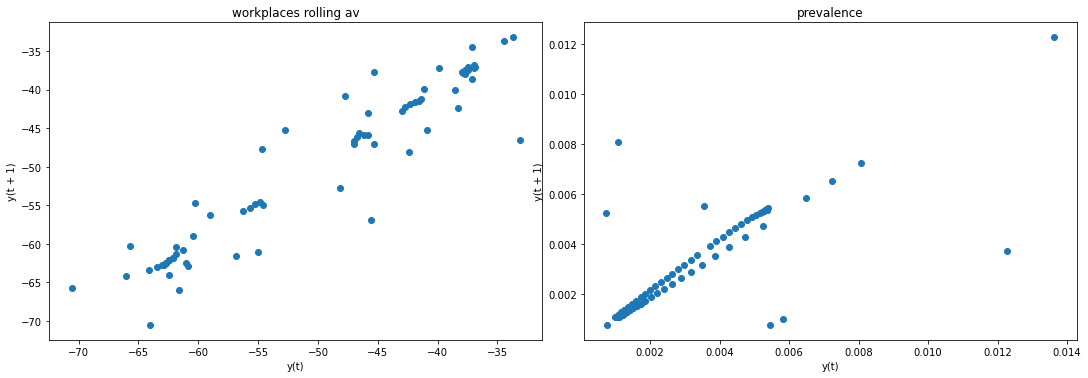

In [9]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av');

lag_plot(london['p'], ax=ax5)
ax5.set_title('prevalence');

In [10]:
raw_london = london.copy(deep=True)

In [11]:
# Differencing - using the rolling average as clear differencing needed, and as well as prevalence

london['workplaces_av'] = london['workplaces_av'] - london['workplaces_av'].shift(1)
london['p'] = london['p'] - london['p'].shift(1)
london = london.dropna()
london.head()

,workplaces_av,p
2020-05-02,-4.142857,-0.001359
2020-09-14,-5.714286,-0.008553
2020-09-15,-4.571429,0.000187
2020-09-16,7.428571,0.000185
2020-09-17,7.571429,0.000181


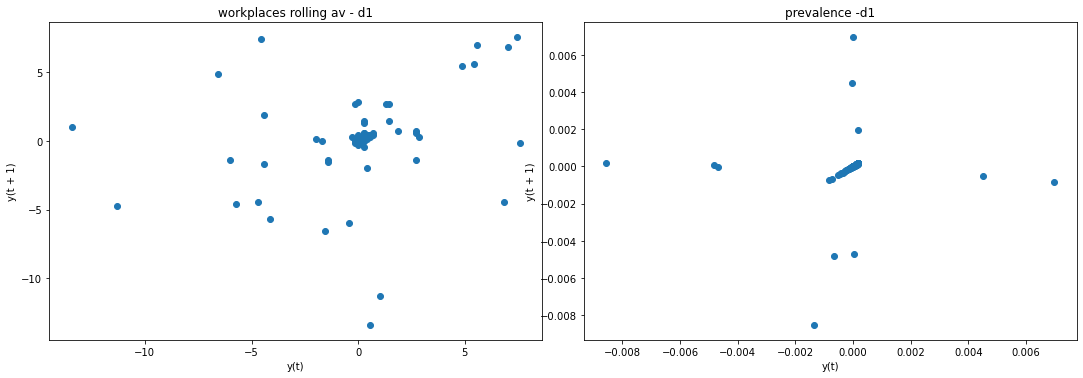

In [12]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('prevalence -d1');

In [13]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
from statsmodels.tsa.stattools import adfuller

X1 = np.array(london['workplaces_av'])
X1 = X1[~np.isnan(X1)]

result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
X2 = np.array(london['p'])
X2 = X2[~np.isnan(X2)]

result = adfuller(X2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    


ADF Statistic: -4.557239
p-value: 0.000155
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
ADF Statistic: -6.327225
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589


In [14]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary

from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(X1)
kpss_test(X2)

# now stationary

KPSS Statistic: 0.21569391228543755
p-value: 0.1
num lags: 12
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.3869269441108714
p-value: 0.08279011029703819
num lags: 12
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Overall result to far: the data is stationary

In [23]:
# split data into train and test. We will need this later for VAR analysis

msk = np.random.rand(len(london)) < 0.8
train = london[msk]
test = london[~msk]

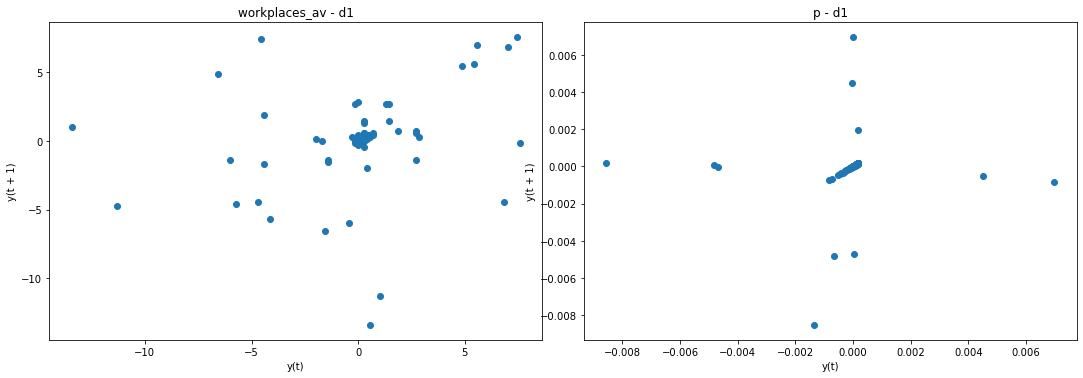

In [33]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces_av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('p - d1');


plt.show()

Result: lag plot is confirmatory with ADF test and KPSS. Uses moving average and 3 differences

Next: setting up VAR model

**Step 2**: Let the maximum order of integration for the group of time-series be d. So, if there are two time-series and one is found to be I(1) and the other is I(2), then d = 2. If one is I(0) and the other is I(1), then m = 1, etc.

**Result**: Saw above that in this case d=1

**Step 3**: Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, **you must not difference the data, no matter what you found at Step 1**.

**Step 4**: Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.


**Note**: try running like this first, then incorporate info on the lag later


In [21]:
# obtain the lag P for VAR

raw_london = raw_london.dropna()
model = VAR(np.array(raw_london)) #recall that rawData is w/o difference operation


In [22]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  -10.615063505949294
BIC :  -10.431058242242477
FPE :  2.4545514721413373e-05
HQIC:  -10.541526102213467 

Lag Order = 2
AIC :  -10.69293117929124
BIC :  -10.383932764153066
FPE :  2.2713864233966e-05
HQIC:  -10.56955150517245 

Lag Order = 3
AIC :  -11.033831615767166
BIC :  -10.597927408944756
FPE :  1.6164437842872218e-05
HQIC:  -10.859944068393334 

Lag Order = 4
AIC :  -11.058069401441575
BIC :  -10.493298580336493
FPE :  1.5799255195560866e-05
HQIC:  -10.83299847500874 

Lag Order = 5
AIC :  -11.164404410864917
BIC :  -10.468756430054455
FPE :  1.4238200423374222e-05
HQIC:  -10.887464889701395 

Lag Order = 6
AIC :  -11.250856113355198
BIC :  -10.4222691161288
FPE :  1.3105181089159394e-05
HQIC:  -10.92135332231569 

Lag Order = 7
AIC :  -11.16998969794507
BIC :  -10.206348879923917
FPE :  1.4282201981258667e-05
HQIC:  -10.787219818332696 

Lag Order = 8
AIC :  -11.16878452003962
BIC :  -10.067920445310538
FPE :  1.4402847742012087e-05
HQIC:  -10.7320349803862

**Result**: The lag order p=6 on the basis of AIC  
**Step 5**: Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [25]:
model = VAR(np.asarray(train))
model_fitted = model.fit(6)

In [27]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(london.columns, out):
    print(col, ':', round(val, 2))

workplaces_av : 2.0
p : 1.96


**Result**: There is no significant correlation between in the residuals

**Step 6**: If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen’s methodology (based on your VAR) for a reliable result.  

**Johansen's test**:   
H0: There are no cointegrating equations 

In [45]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import JohansenTestResult

# Function from here : http://web.pdx.edu/~crkl/ceR/Python/example14_3.py

"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""



def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

result = coint_johansen(np.asarray(london),0,1)
joh_output(result)

   max_eig_stat  trace_stat
0     62.199644   82.038924
1     19.839280   19.839280 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



**Result**: Greater than all critical values, thus p<0.05 - Thus rejecting the null hypothesis. Thus they are cointegrated.  
**Step 7**: No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.  
**Step 8**: Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.  

In [49]:
model = VAR(np.asarray(train))
model_fitted = model.fit(6)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

6


**Step 9 and Step 10**: Test for Granger non-causality. It’s essential that you don’t include the coefficients for the ‘extra’ m lags when you perform the tests. They are there just to fix up the asymptotics.

^ I'm not sure I've done step 8 right, and not sure what it means by the 'extra' lags above?

In [50]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=lag_order #becuase we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

o = grangers_causation_matrix(train, variables = train.columns)  

In [60]:
o

,workplaces_av_x,p_x
workplaces_av_y,1.0000,0.0136
p_y,0.0066,1.0000


In [61]:
print("p value for prevalence causing mobility is:",o.iloc[0,1],'\n')
print("p value for mobility causing prevalence is:",o.iloc[1,0],'\n')

p value for prevalence causing mobility is: 0.0136 

p value for mobility causing prevalence is: 0.0066 



**Result**: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). // Both p values < 0.05 therefore they each cause eachother...

**Step 11**: Finally, look back at what you concluded in Step 6 about cointegration. //

If two or more time-series are cointegrated, then there must be Granger causality between them - either one-way or in both directions. However, the converse is not true.

So, if your data are cointegrated but you don't find any evidence of causality, you have a conflict in your results. (This might occur if your sample size is too small to satisfy the asymptotics that the cointegration and causality tests rely on.) If you have cointegration and find one-way causality, everything is fine. (You may still be wrong about there being no causality in the other direction.) If your data are not cointegrated, then you have no cross-check on your causality results.
